In [12]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the subfolders and their corresponding values
# subfolders = {
#     "fully_open": 1,
#     "partially_open": 1,
#     "half_open": 1,
#     "partially_closed": 0,
#     "fully_closed": 0,
# }

subfolders = {
    "close": 0,
    "open": 1,
}

# Custom Dataset
class EyeDataset(Dataset):
    def __init__(self, root_dir, subfolders, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for subfolder, label in subfolders.items():
            folder_path = os.path.join(root_dir, subfolder)
            for filename in os.listdir(folder_path):
                if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.data.append(os.path.join(folder_path, filename))
                    self.labels.append(label)

        print(f"Loaded {len(self.data)} images from {len(subfolders)} subfolders.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


# Define the model
class EyeOpennessModel(nn.Module):
    def __init__(self):
        super(EyeOpennessModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 64 * 64, 128),  # Adjust input size based on image dimensions
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

Using device: cuda


In [13]:
# Paths and parameters
root_dir = "/home/r3kste/code/mfw_sleep/output"
batch_size = 16
num_epochs = 10
learning_rate = 0.001

# Transformations
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

# Load dataset
print("Loading dataset...")
dataset = EyeDataset(root_dir, subfolders, transform=transform)

# Use all images for training
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, loss, and optimizer
model = EyeOpennessModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}")

print("Training complete.")

Loading dataset...
Loaded 93 images from 2 subfolders.
Starting training...
Epoch 1/10, Train Loss: 1.4453
Epoch 2/10, Train Loss: 0.6873
Epoch 3/10, Train Loss: 0.6584
Epoch 4/10, Train Loss: 0.5322
Epoch 5/10, Train Loss: 0.3198
Epoch 6/10, Train Loss: 0.2387
Epoch 7/10, Train Loss: 0.2270
Epoch 8/10, Train Loss: 0.2149
Epoch 9/10, Train Loss: 0.2159
Epoch 10/10, Train Loss: 0.1965
Training complete.


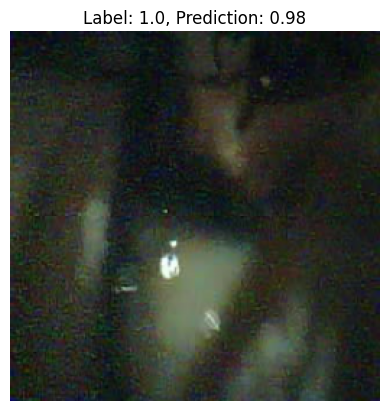

In [6]:
# Show a random image from the test set
# show the predicted value and the actual value
# use matplotlib to show the image

import matplotlib.pyplot as plt
import random
import numpy as np


def show_image(image, label, prediction):
    image = image.permute(1, 2, 0).cpu().numpy()  # Change the order of dimensions
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    plt.imshow(image)
    plt.title(f"Label: {label}, Prediction: {prediction:.2f}")
    plt.axis("off")
    plt.show()


# Show a random image from the test set
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
with torch.no_grad():
    prediction = model(image).item()  # Get the prediction
show_image(image.squeeze(), label.item(), prediction)


In [14]:
torch.save(model.state_dict(), "anton.pth")
print("Model saved as eye_openness_model.pth")

Model saved as eye_openness_model.pth


In [ ]:
# take some 10 random images from the test set and save them
# with the predicted value and the actual value

import matplotlib.pyplot as plt
import random
import numpy as np


def save_image(image, label, prediction, index):
    image = image.permute(1, 2, 0).cpu().numpy()  # Change the order of dimensions
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    plt.imshow(image)
    plt.title(f"Label: {label:.2f}, Prediction: {prediction:.2f}")
    plt.axis("off")
    plt.savefig(f"o
    plt.close()


# Create a directory to save the images
output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)

# Save 10 random images from the test set
for i in range(10):
    random_index = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[random_index]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        prediction = model(image).item()  # Get the prediction
    save_image(image.squeeze(), label.item(), prediction, i)
    print(f"Saved image_{i}.png with Label: {label:.2f}, Prediction: {prediction:.2f}")


In [ ]:
# 